In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 86% 52.0M/60.3M [00:00<00:00, 186MB/s]
100% 60.3M/60.3M [00:00<00:00, 186MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/emotion

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# **Preprocessing and Visualization of the Data**

In [5]:
# removing anything other then png, jpg,jpeg

import cv2
import imghdr
import os

img_exts = ['png','jpg','jpeg']

data_dir = '/content/emotion'

for root, dirs, files in os.walk(data_dir):
    for file in files:

        file_path = os.path.join(root, file)

        try:
          file_type = imghdr.what(file_path)

          if file_type not in (img_exts):
            print(f" Image not in exts list {file_path}")
            os.remove(file_path)
          else :
            img = cv2.imread(file_path)

        except Exception as e:
          print(f'Issue with file {file_path}. Error: {e}')
          os.remove(file_path)


In [6]:
happy_img = os.listdir( '/content/emotion/train/happy')
angry_img=os.listdir('/content/emotion/train/angry')
disgust_img=os.listdir('/content/emotion/train/disgust')
fear_img=os.listdir('/content/emotion/train/fear')
neutral_img=os.listdir('/content/emotion/train/neutral')
sad_img=os.listdir('/content/emotion/train/sad')
surprise_img=os.listdir('/content/emotion/train/surprise')

class_face =['Angry','Disgust','fear','happy','neutral','sad','surprise']
count = [len(angry_img),len(disgust_img),len(fear_img),len(happy_img),len(neutral_img),len(sad_img),len(surprise_img)]
total_count=len(angry_img)+len(disgust_img)+len(fear_img)+len(happy_img)+len(neutral_img)+len(sad_img)+len(surprise_img)
print(f'Total count of images is {total_count}')
print (class_face,"\n", count )

Total count of images is 28709
['Angry', 'Disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] 
 [3995, 436, 4097, 7215, 4965, 4830, 3171]


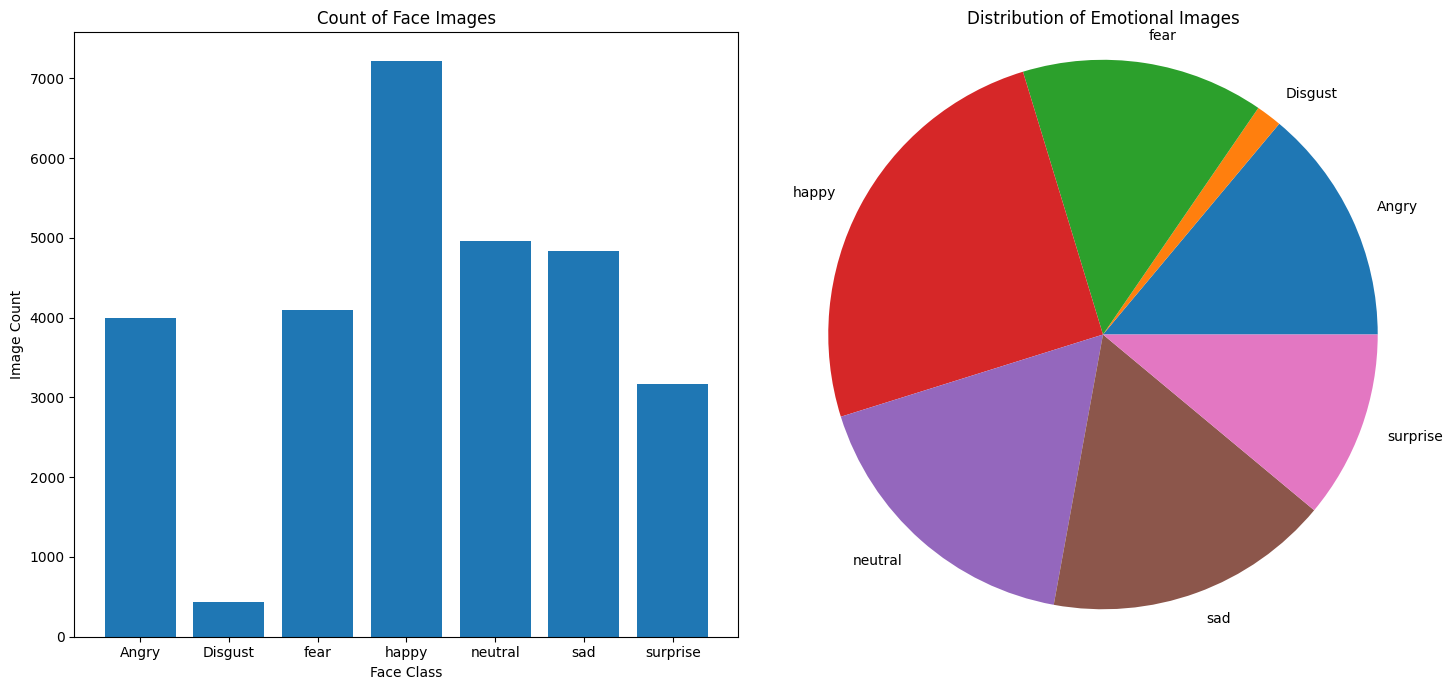

In [7]:
fig , ax = plt.subplots(1 , 2,figsize=(15,7))

# bar plot 28709
ax[0].bar(class_face, count)
ax[0].set_xlabel('Face Class')
ax[0].set_ylabel('Image Count')
ax[0].set_title('Count of Face Images')


# pie plot
ax[1].pie( count,labels=class_face)
ax[1].set_title('Distribution of Emotional Images')
ax[1].axis('equal')

plt.tight_layout()
plt.show()

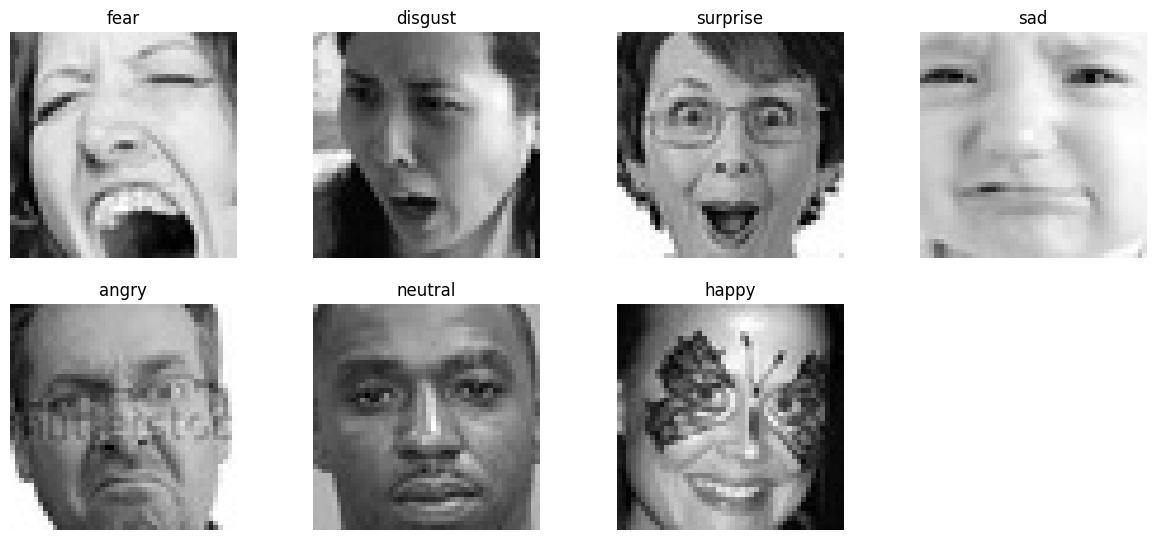

In [8]:
train_dir='/content/emotion/train'

emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i,emotion in enumerate(emotions,1):
  folder = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder,os.listdir(folder)[5])
  img=plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

In [9]:
def plot_img_from_dir(dir_path,class_face,num_img=9):

   img_filename = os.listdir(dir_path)

   if len(img_filename) < num_img :
      print(f"only found {len(img_filename)} images in {dir_path}, display them all")
      num_images =len(img_filename)

   selected_img = random.sample(img_filename,num_img)

   fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Adjust the size as needed
   axes = axes.ravel()

   for i, image_file in enumerate(selected_img):
        image_path = os.path.join(dir_path, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_face}")
        axes[i].axis('off')  # Hide the axis

   plt.tight_layout()
   plt.show()

In [10]:
img_path = '/content/emotion/train/happy/Training_10552916.jpg'

import cv2

img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)

if img is not None :
  print('Shape:',img.shape)
else:
  print('The image could not be loaded')

Shape: (48, 48)


# **Model Building**

In [11]:
train_dir ='/content/emotion/train'
test_dir = '/content/emotion/test'

img_width , img_height = 48,48
batch_size =64
epochs = 20
num_classes = 7

In [12]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

train_datagen =data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode ='categorical',
    color_mode='grayscale',
    subset='training')

validation_datagen= data_generator.flow_from_directory(
      train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode ='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_dir ,
     target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode ='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [13]:
train_class_label =train_datagen.class_indices
print('Training class labels:',train_class_label)

valid_class_label=validation_datagen.class_indices
print('validation class labels:',valid_class_label)

test_class_label =test_generator.class_indices
print('Test class labels:',test_class_label)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [14]:
model=Sequential()
model.add(Conv2D(32 , kernel_size=(3,3),padding='same',activation='relu',input_shape=(48,48,1)))
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

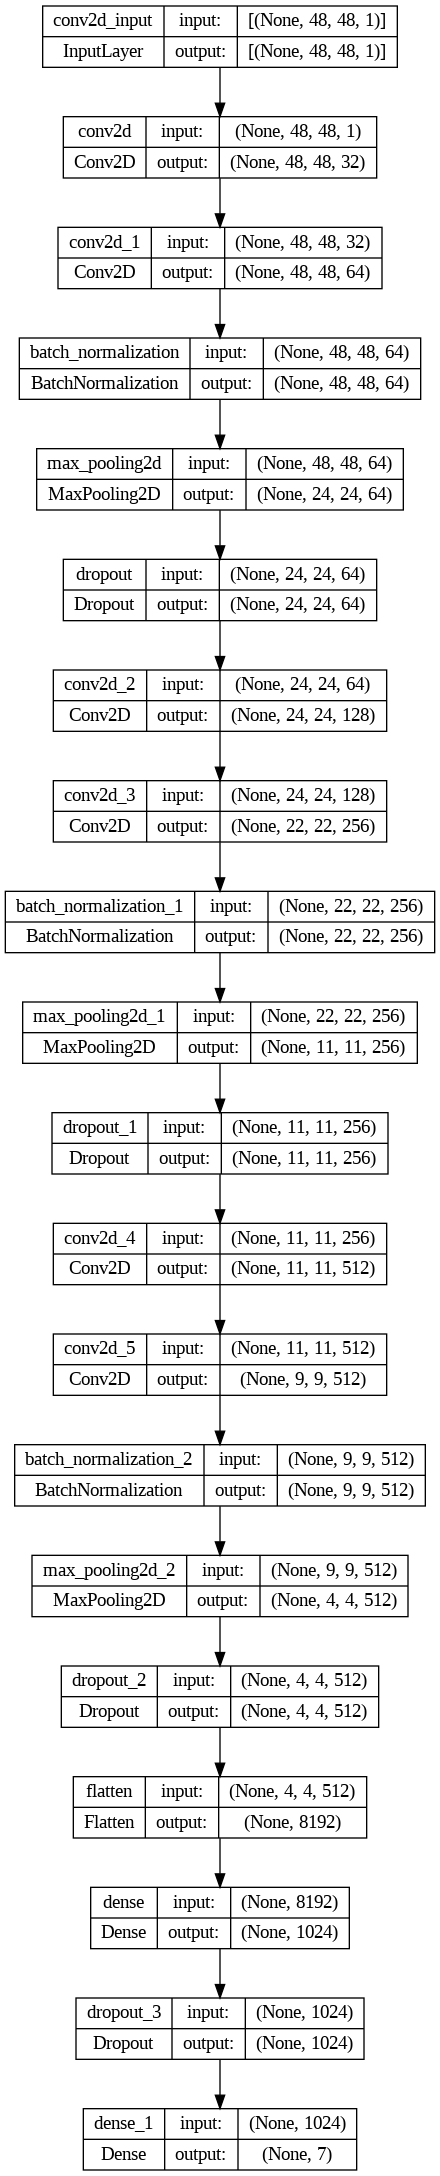

In [18]:
plot_model(model,to_file='/content/emotion/model.png',
           show_shapes=True,show_layer_names=True)

In [19]:
cnn_path = '/content/CNN_BASIC'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/CNN_BASIC/Custom_CNN_model.keras'

In [20]:
# checkpoint to save

checkpoint = ModelCheckpoint(
          filepath =chk_path ,
           save_best_only=True,
          verbose=1,
          mode='min',
          monitor='val_loss'
)

In [21]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [22]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [23]:
# saving the log into a csv file
csv_logger = CSVLogger(os.path.join(cnn_path ,'training.log'))

In [24]:
# saving every callback into a list
callbacks=[checkpoint,earlystop,reduce_lr,csv_logger]

In [25]:
train_steps_per_epoch = train_datagen.samples // train_datagen.batch_size + 1
validation_steps_epoch = validation_datagen.samples // validation_datagen.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [26]:
history = model.fit(
    train_datagen,
    steps_per_epoch =train_steps_per_epoch,
    epochs = 20 ,
    validation_data=validation_datagen,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks  )

Epoch 1/20
359/359 [==============================] - ETA: 0s - loss: 12.5186 - accuracy: 0.2751
Epoch 1: val_loss improved from inf to 11.81884, saving model to /content/CNN_BASIC/Custom_CNN_model.keras
359/359 [==============================] - 40s 82ms/step - loss: 12.5186 - accuracy: 0.2751 - val_loss: 11.8188 - val_accuracy: 0.2865 - lr: 1.0000e-04
Epoch 2/20
359/359 [==============================] - ETA: 0s - loss: 10.4514 - accuracy: 0.3601
Epoch 2: val_loss improved from 11.81884 to 9.64029, saving model to /content/CNN_BASIC/Custom_CNN_model.keras
359/359 [==============================] - 25s 68ms/step - loss: 10.4514 - accuracy: 0.3601 - val_loss: 9.6403 - val_accuracy: 0.3853 - lr: 1.0000e-04
Epoch 3/20
359/359 [==============================] - ETA: 0s - loss: 8.5822 - accuracy: 0.4059
Epoch 3: val_loss improved from 9.64029 to 7.69684, saving model to /content/CNN_BASIC/Custom_CNN_model.keras
359/359 [==============================] - 24s 68ms/step - loss: 8.5822 - accur

In [27]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

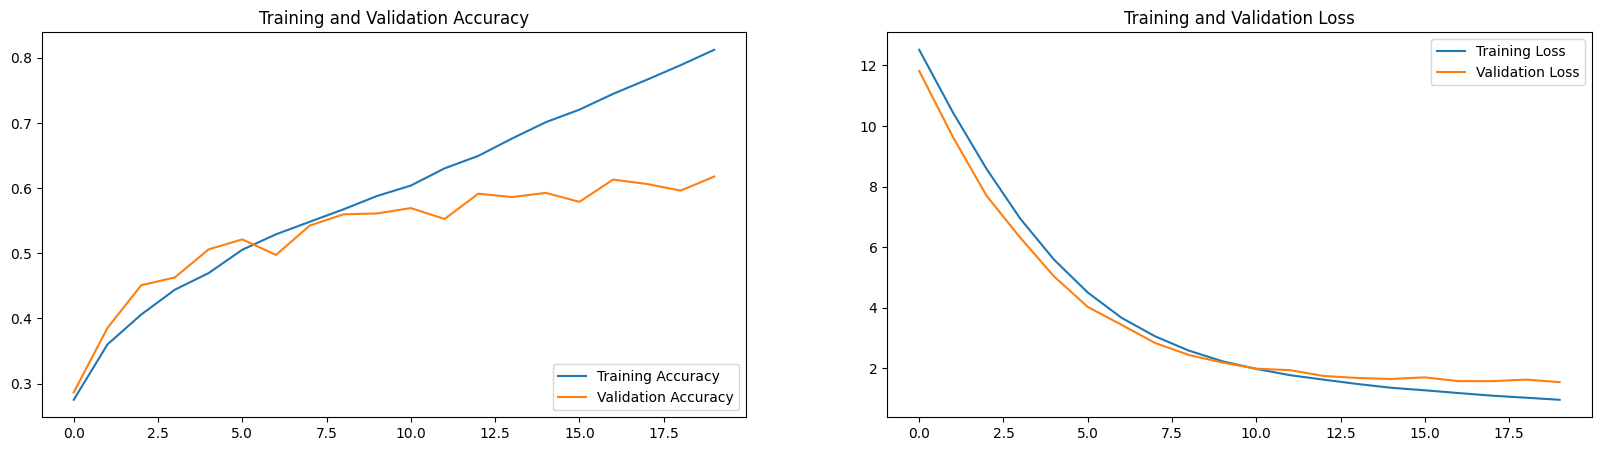

In [28]:
plot_training_history(history)

In [30]:
train_loss, train_accu = model.evaluate(train_datagen)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 26ms/step - loss: 1.5237 - accuracy: 0.6304
final train accuracy = 92.16 , validation accuracy = 63.04


113/113 [==============================] - 7s 54ms/step


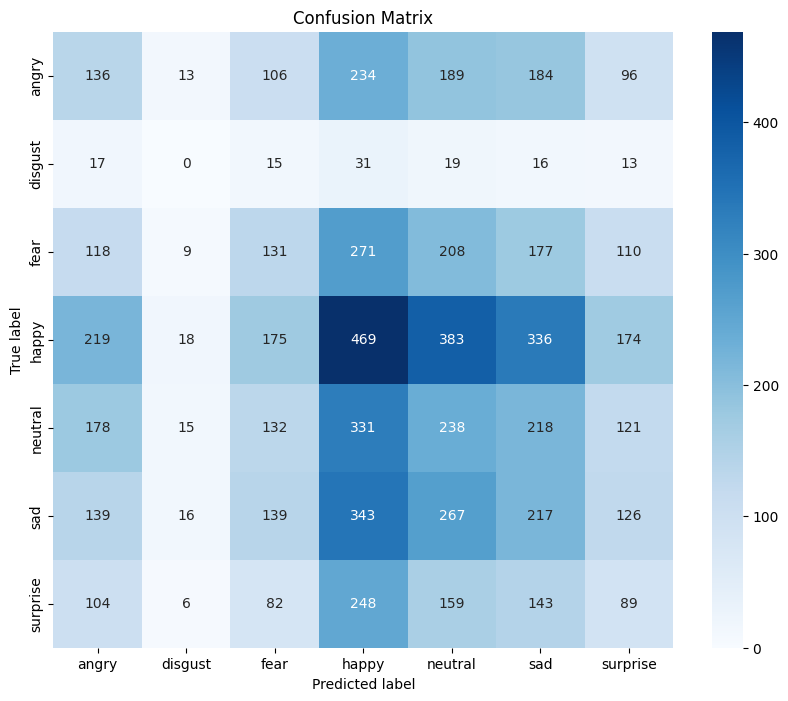

In [31]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
# Printing the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.14      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.13      0.15      1024
       happy       0.24      0.26      0.25      1774
     neutral       0.16      0.19      0.18      1233
         sad       0.17      0.17      0.17      1247
    surprise       0.12      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.18      7178



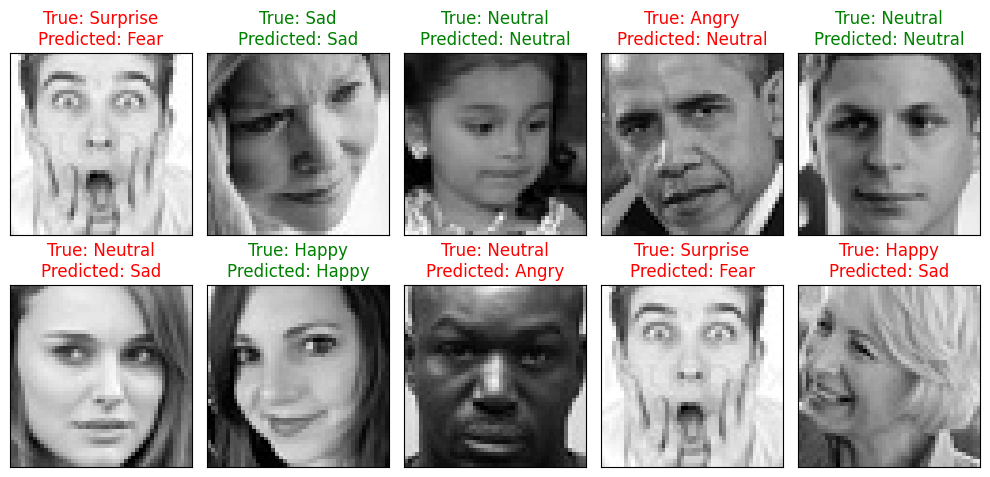

In [34]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # #################### Making a prediction using the model  ########################@@@@@@
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2 Data Augmentation

In [38]:
train_dir='/content/emotion/train'
test_dir='/content/emotion/test'



#  the parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7


# data generator

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_data_generator = ImageDataGenerator(rescale=1./255)

train_datagen =data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode ='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_datagen=data_generator.flow_from_directory(
      train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode ='categorical',
    color_mode='grayscale' ,
      subset='validation')


test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [39]:
model=Sequential()
model.add(Conv2D(32 , kernel_size=(3,3),padding='same',activation='relu',input_shape=(48,48,1)))
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 128)      

In [41]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [44]:
cnn_path = '/content/CNN_AUG'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [46]:
train_steps_per_epoch =train_datagen.samples // train_datagen.batch_size + 1
validation_steps_epoch = validation_datagen.samples // validation_datagen.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_datagen,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_datagen,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/100
359/359 [==============================] - ETA: 0s - loss: 12.5879 - accuracy: 0.2186
Epoch 1: val_loss improved from inf to 12.02418, saving model to /content/CNN_AUG/Custom_CNN_augmented_model.keras
359/359 [==============================] - 39s 94ms/step - loss: 12.5879 - accuracy: 0.2186 - val_loss: 12.0242 - val_accuracy: 0.2369 - lr: 1.0000e-04
Epoch 2/100
359/359 [==============================] - ETA: 0s - loss: 10.4965 - accuracy: 0.2389
Epoch 2: val_loss improved from 12.02418 to 10.18017, saving model to /content/CNN_AUG/Custom_CNN_augmented_model.keras
359/359 [==============================] - 31s 86ms/step - loss: 10.4965 - accuracy: 0.2389 - val_loss: 10.1802 - val_accuracy: 0.2599 - lr: 1.0000e-04
Epoch 3/100
359/359 [==============================] - ETA: 0s - loss: 8.5710 - accuracy: 0.2521
Epoch 3: val_loss improved from 10.18017 to 7.83595, saving model to /content/CNN_AUG/Custom_CNN_augmented_model.keras
359/359 [==============================] - 32s 88

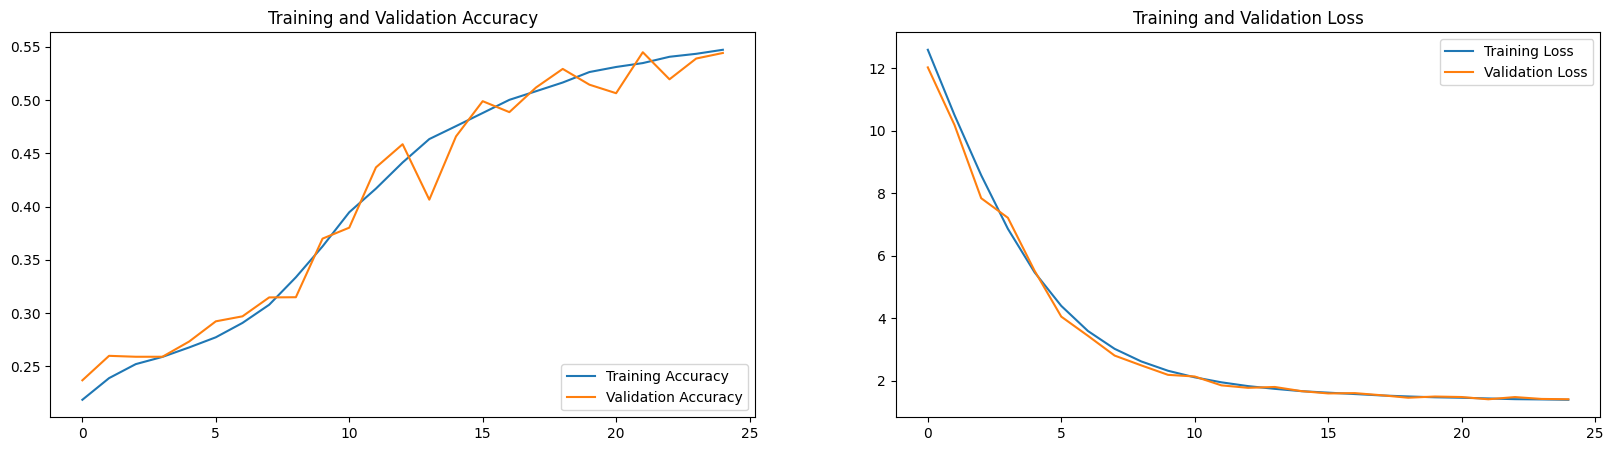

In [47]:
plot_training_history(history)

In [48]:
train_loss , train_acc = model.evaluate(train_datagen)
test_loss , test_acc = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))


113/113 [==============================] - 4s 34ms/step - loss: 1.2999 - accuracy: 0.5794
final train accuracy = 55.80 , validation accuracy = 57.94


113/113 [==============================] - 3s 27ms/step


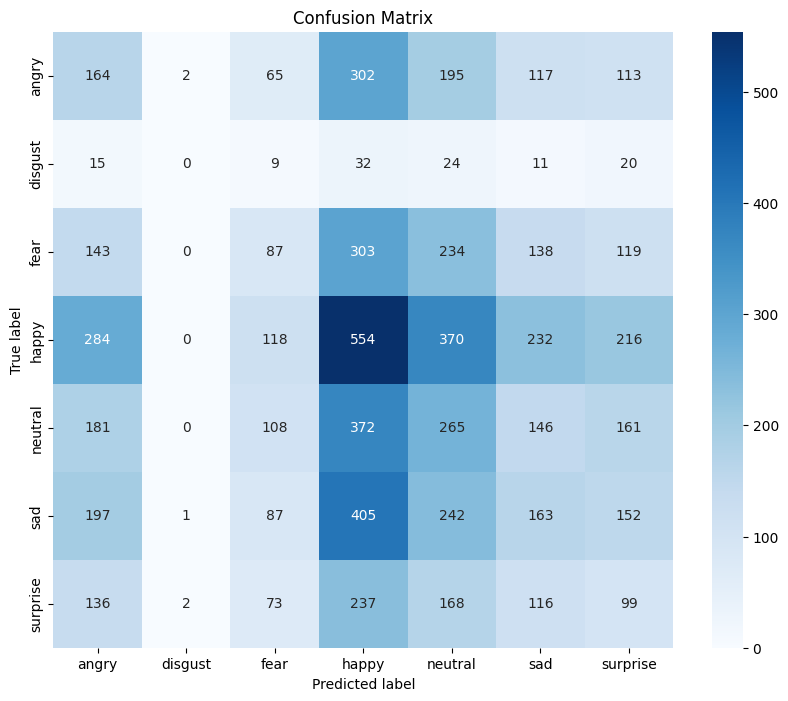

In [49]:
# Assuming the true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.15      0.17      0.16       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.08      0.11      1024
       happy       0.25      0.31      0.28      1774
     neutral       0.18      0.21      0.19      1233
         sad       0.18      0.13      0.15      1247
    surprise       0.11      0.12      0.12       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.18      0.19      0.18      7178

